In [1]:
import pandas as pd
import numpy as np
import operator
import json

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("admission_data.csv")
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,242,317,103,2,2.5,2.0,8.15,0,0.65
1,334,319,108,3,3.0,3.5,8.54,1,0.71
2,4,322,110,3,3.5,2.5,8.67,1,0.80
3,45,326,113,5,4.5,4.0,9.40,1,0.91
4,232,319,106,3,3.5,2.5,8.33,1,0.74


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']],
    data[['Chance of Admit']],
    test_size=0.2,
    random_state=0)

In [4]:
for col in X_train:
    mean = X_train[col].mean()
    std = X_train[col].std()
    X_train[col] = (X_train[col] - mean)/std
    X_test[col] = (X_test[col]-mean)/std


In [5]:
X_train['Ones'] = [1]*len(X_train)
X_test['Ones'] = [1]*len(X_test)

In [6]:
class LinearRegression:
    theta = None
    
    def predict(self, X):
        Y_pred = np.dot(X.values,self.theta.T)
        return Y_pred
    
    def compute_error(self, y_pred, y_actual, regularization_method, l):
        m = len(y_actual)
        error = (1.0/float(m))*np.sum((y_pred-y_actual)*(y_pred-y_actual))
        reg_term = 0
        if regularization_method == 'lasso':
            reg_term = np.sum(np.abs(self.theta))
        if regularization_method == 'ridge':
            reg_term = np.sum(np.square(self.theta))
            
        error = error + (l*reg_term)
        return error
    
    def compute_gradient(self, X, h, Y,regularization_method,l):
        m = len(Y)
        grad = (2.0/float(m))*np.sum(X*(h-Y), axis=0)
        reg_term = 0
        if regularization_method == 'lasso':
            reg_term = np.sum(np.divide(self.theta,np.abs(self.theta)))
        if regularization_method == 'ridge':
            reg_term = 2*np.sum(self.theta)
            
        grad = grad + (l*reg_term)
        return grad
    
    def train(self, X_train, y_train, alpha, max_epochs, regularization_method,l):
        self.theta = None
        self.theta = np.random.rand(1,X_train.shape[1])
        m = len(X_train)
        its = list()
        errs = list()
        for i in range(0,max_epochs):
            X = X_train.values
            h = np.dot(X,self.theta.T)
            Y = y_train.values
            self.theta = self.theta - alpha*self.compute_gradient(X,h,Y,regularization_method,l)
            
            y_pred = np.dot(X,self.theta.T)
            err = self.compute_error(y_pred,y_train.values, regularization_method,l)
            its.append((i+1))
            errs.append(err)
        return (its,errs)
            

In [7]:
ln_mse = LinearRegression()
its_mse,errs_mse = ln_mse.train(X_train,y_train,0.1, 100,'ridge',0.01)
y_train_pred_mse = ln_mse.predict(X_train)
y_test_pred_mse = ln_mse.predict(X_test)

In [8]:
train_mse = ln_mse.compute_error(y_train_pred_mse, y_train.values,'ridge',0.01)
test_mse = ln_mse.compute_error(y_test_pred_mse, y_test.values,'ridge',0.01)
print '*****************MEAN SQUARED ERROR*****************'
print
print 'Train set error : '+str(train_mse)
print 'Test set error : '+str(test_mse)
print
print '****************************************************'
print

*****************MEAN SQUARED ERROR*****************

Train set error : 0.00904482723653473
Test set error : 0.008567049286317128

****************************************************



In [9]:
lasso_reg_params = np.arange(0,0.01,0.00005)
lasso_train_errs = list()
lasso_test_errs = list()
for reg_param in lasso_reg_params:
    ln_mse = LinearRegression()
    ln_mse.train(X_train,y_train,0.1,100,'lasso',reg_param)
    y_train_pred_mse = ln_mse.predict(X_train)
    y_test_pred_mse = ln_mse.predict(X_test)
    lasso_train_errs.append(ln_mse.compute_error(y_train_pred_mse, y_train.values,'lasso',reg_param))
    lasso_test_errs.append(ln_mse.compute_error(y_test_pred_mse, y_test.values,'lasso',reg_param))

In [10]:
ridge_reg_params = np.arange(0,0.01,0.00005)
ridge_train_errs = list()
ridge_test_errs = list()
for reg_param in ridge_reg_params:
    ln_mse = LinearRegression()
    ln_mse.train(X_train,y_train,0.1,100,'ridge',reg_param)
    y_train_pred_mse = ln_mse.predict(X_train)
    y_test_pred_mse = ln_mse.predict(X_test)
    ridge_train_errs.append(ln_mse.compute_error(y_train_pred_mse, y_train.values,'ridge',reg_param))
    ridge_test_errs.append(ln_mse.compute_error(y_test_pred_mse, y_test.values,'ridge',reg_param))

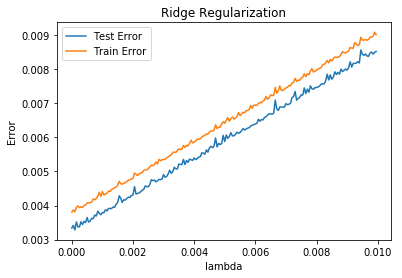

In [11]:
df = pd.DataFrame({'Train Error': ridge_train_errs, 'Test Error':ridge_test_errs}, index=ridge_reg_params)
lines = df.plot.line()
lines.set_title('Ridge Regularization')
lines.set_xlabel('lambda')
lines.set_ylabel('Error')

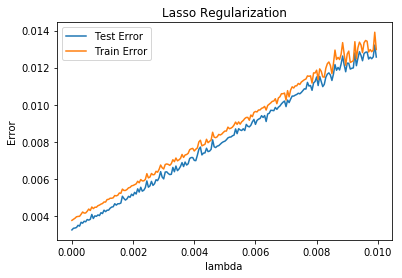

In [12]:
df = pd.DataFrame({'Train Error': lasso_train_errs, 'Test Error':lasso_test_errs}, index=lasso_reg_params)
lines = df.plot.line()
lines.set_title('Lasso Regularization')
lines.set_xlabel('lambda')
lines.set_ylabel('Error')

In [13]:
lasso_reg_params = np.arange(0,10,0.1)
lasso_train_errs = list()
lasso_test_errs = list()
for reg_param in lasso_reg_params:
    ln_mse = LinearRegression()
    ln_mse.train(X_train,y_train,0.1,100,'lasso',reg_param)
    y_train_pred_mse = ln_mse.predict(X_train)
    y_test_pred_mse = ln_mse.predict(X_test)
    lasso_train_errs.append(ln_mse.compute_error(y_train_pred_mse, y_train.values,'lasso',reg_param))
    lasso_test_errs.append(ln_mse.compute_error(y_test_pred_mse, y_test.values,'lasso',reg_param))

In [14]:
ridge_reg_params = np.arange(0,10,0.1)
ridge_train_errs = list()
ridge_test_errs = list()
for reg_param in ridge_reg_params:
    ln_mse = LinearRegression()
    ln_mse.train(X_train,y_train,0.1,100,'ridge',reg_param)
    y_train_pred_mse = ln_mse.predict(X_train)
    y_test_pred_mse = ln_mse.predict(X_test)
    ridge_train_errs.append(ln_mse.compute_error(y_train_pred_mse, y_train.values,'ridge',reg_param))
    ridge_test_errs.append(ln_mse.compute_error(y_test_pred_mse, y_test.values,'ridge',reg_param))

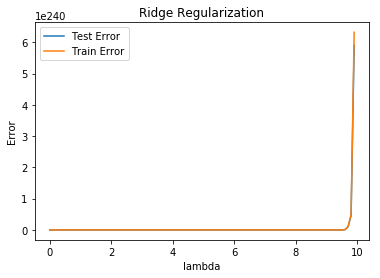

In [15]:
df = pd.DataFrame({'Train Error': ridge_train_errs, 'Test Error':ridge_test_errs}, index=ridge_reg_params)
lines = df.plot.line()
lines.set_title('Ridge Regularization')
lines.set_xlabel('lambda')
lines.set_ylabel('Error')

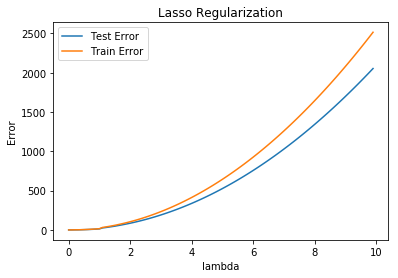

In [16]:
df = pd.DataFrame({'Train Error': lasso_train_errs, 'Test Error':lasso_test_errs}, index=lasso_reg_params)
lines = df.plot.line()
lines.set_title('Lasso Regularization')
lines.set_xlabel('lambda')
lines.set_ylabel('Error')